Copyright 2020 The TensorFlowTTS Team. All Rights Reserved.
Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
!pip install parallel_wavegan

In [2]:
import tensorflow as tf
import torch

from tensorflow_tts.models import TFParallelWaveGANGenerator
from tensorflow_tts.configs import ParallelWaveGANGeneratorConfig

from parallel_wavegan.models import ParallelWaveGANGenerator
import numpy as np

/home/lap13548/anaconda3/envs/tensorflow-tts/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [3]:
tf_model = TFParallelWaveGANGenerator(config=ParallelWaveGANGeneratorConfig(), name="parallel_wavegan_generator")

In [4]:
tf_model._build()

In [5]:
tf_model.summary()

Model: "parallel_wavegan_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_convolution (TFConv1d1 multiple                  128       
_________________________________________________________________
tf_conv_in_upsample_net_work multiple                  32036     
_________________________________________________________________
residual_block_._0 (TFResidu multiple                  43264     
_________________________________________________________________
residual_block_._1 (TFResidu multiple                  43264     
_________________________________________________________________
residual_block_._2 (TFResidu multiple                  43264     
_________________________________________________________________
residual_block_._3 (TFResidu multiple                  43264     
_________________________________________________________________
residual_block_._4 (TFResidu multiple   

In [6]:
torch_checkpoints = torch.load("./checkpoint-400000steps.pkl", map_location=torch.device('cpu'))

In [7]:
torch_generator_weights = torch_checkpoints["model"]["generator"]

In [8]:
torch_model = ParallelWaveGANGenerator()

In [9]:
torch_model.load_state_dict(torch_checkpoints["model"]["generator"])

<All keys matched successfully>

In [10]:
torch_model.remove_weight_norm()

In [11]:
model_parameters = filter(lambda p: p.requires_grad, torch_model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1334309

In [12]:
# in pytorch, in convolution layer, the order is bias -> weight, in tf it is weight -> bias. We need re-order.

def convert_weights_pytorch_to_tensorflow(weights_pytorch):
    """
    Convert pytorch Conv1d weight variable to tensorflow Conv2D weights.
    1D: Pytorch (f_output, f_input, kernel_size) -> TF (kernel_size, f_input, 1, f_output)
    2D: Pytorch (f_output, f_input, kernel_size_h, kernel_size_w) -> TF (kernel_size_w, kernel_size_h, f_input, 1, f_output)
    """
    if len(weights_pytorch.shape) == 3: # conv1d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1))  # [f_output, kernel_size, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2))  # [kernel-size, f_output, f_input]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1))  # [kernel-size, f_input, f_output]
        return weights_tensorflow
    elif len(weights_pytorch.shape) == 1: # conv1d-bias
        return weights_pytorch
    elif len(weights_pytorch.shape) == 4: # conv2d-kernel
        weights_tensorflow = np.transpose(weights_pytorch, (0,2,1,3))  # [f_output, kernel_size_h, f_input, kernel_size_w]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_h, f_output, f_input, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, f_input, f_output, kernel-size-w]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,1,3,2))  # [kernel_size_h, f_input, kernel-size-w, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (0,2,1,3))  # [kernel_size_h, kernel-size-w, f_input, f_output]
        weights_tensorflow = np.transpose(weights_tensorflow, (1,0,2,3))  # [kernel-size_w, kernel_size_h, f_input, f_output]
        return weights_tensorflow

torch_weights = []
all_keys = list(torch_model.state_dict().keys())
all_values = list(torch_model.state_dict().values())

idx_already_append = []

for i in range(len(all_keys) -1):
    if i not in idx_already_append:
        if all_keys[i].split(".")[0:-1] == all_keys[i + 1].split(".")[0:-1]:
            if all_keys[i].split(".")[-1] == "bias" and all_keys[i + 1].split(".")[-1] == "weight":
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i + 1].cpu().detach().numpy()))
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)
                idx_already_append.append(i + 1)
        else:
            if i not in idx_already_append:
                torch_weights.append(convert_weights_pytorch_to_tensorflow(all_values[i].cpu().detach().numpy()))
                idx_already_append.append(i)

In [13]:
tf_var = tf_model.trainable_variables

In [14]:
for i, var in enumerate(tf_var):
    tf.keras.backend.set_value(var, torch_weights[i])

In [15]:
feats = np.load("LJ001-0009-norm-feats.npy")

In [16]:
feats = np.expand_dims(feats, 0)

In [17]:
audio = tf_model(feats)[0, :, 0]

In [18]:
import matplotlib.pyplot as plt

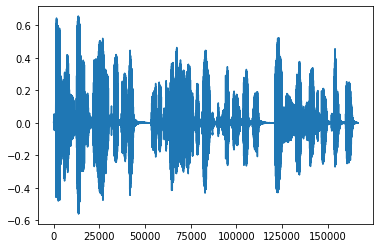

In [19]:
plt.plot(audio)

In [20]:
from IPython.display import Audio

In [21]:
Audio(audio, rate=22050)